In [ ]:
#https://github.com/sainathadapa/attention-primer-pytorch/tree/master/1_counting-letters

# The task is to write a count of the number of elements of a sequence of a fixed size
# consisting of characters A, B, C and the absolute difference of counters A - B

# [A, B, B, C] ->  { A:1, B:2, C:1, A_DIFF_B: 1 }

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import random

## SEED

In [ ]:
torch.use_deterministic_algorithms(True)
SEED = 1 # try to 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## CONSTANTS

In [ ]:
vocabular = ["A", "B", "C"]
query_vocabular = ["CNTR_A", "CNTR_B", "CNTR_C", "CNTR_AB"]

S = 10
E_x = len(vocabular)

L = len(query_vocabular)
E_y = S + 1

E_q = len(query_vocabular)

E_hidden = 64
SQRT_E_k = np.sqrt(E_hidden)

BATCH_SIZE = 100

## DATA

In [ ]:
id_to_char = { i: symbol for i, symbol in enumerate(vocabular)}
char_to_id = { symbol: i for i, symbol in id_to_char.items() }

id_to_query = { i: q for i, q in enumerate(query_vocabular)}
query_to_id = { q: i for i, q in id_to_query.items() }

def get_seq():
  seq = np.random.randint(low=0, high=len(vocabular), size=S)
  return seq

def str_seq(sequence):
  return [id_to_char[i] for i in sequence]

def get_counter(sequence):
  counter = [0 for i in range(L)]
  for seq_id in sequence:
    if id_to_char[seq_id] != "-":
      counter[seq_id] += 1

  counter[-1] = abs(counter[0] - counter[1])

  return np.array(counter)

def str_counter(counter):
  out = { name:0 for name in query_vocabular }
  for counter_id, counter_value in enumerate(counter):
    out[id_to_query[counter_id]] = counter_value
  return out

In [ ]:
seq = get_seq()
counter = get_counter(seq)

print("seq:", seq)
print("counter:", counter)
print("====or====")
print("seq:", str_seq(seq))
print("counter:", str_counter(counter))

seq: [1 0 0 1 1 0 0 1 0 1]
counter: [5 5 0 0]
====or====
seq: ['B', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'A', 'B']
counter: {'CNTR_A': 5, 'CNTR_B': 5, 'CNTR_C': 0, 'CNTR_AB': 0}


## DATASET

In [ ]:
class SequenceCounterDataset(torch.utils.data.Dataset):
  def __init__(self, N):
      self.N = N

  def __getitem__(self, index):
    x = get_seq()
    y = get_counter(x)

    x = torch.Tensor(x).long()
    y = torch.Tensor(y).long()

    return x, y

  def __len__(self):
    return self.N

## MODEL_V1

In [ ]:
# Q = X * W_q
# K = X * W_k
# V = X * W_v
# Attention = softmax(Q*K_T/sqrt(E_k)) * V

class AttentionModel_V1(nn.Module):
  def __init__(self):
    super(AttentionModel_V1, self).__init__()
    self.W_q = nn.Parameter(torch.zeros((E_q, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_q)

    self.W_k = nn.Parameter(torch.zeros((E_x, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_k)

    self.W_v = nn.Parameter(torch.zeros((E_x, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_v)

    self.layer_norm_1 = nn.LayerNorm(E_hidden)

    self.linear_layer_1 = nn.Linear(E_hidden, 32)
    self.layer_norm_2 = nn.LayerNorm(32)

    self.final_dense = nn.Linear(32, E_y)

  def forward(
      self,
      x, # [N, S]
      q  # [N, L]
  ):
    x = torch.nn.functional.one_hot(x, num_classes=E_x).float() # [N, S, E_x]
    q = torch.nn.functional.one_hot(q, num_classes=E_q).float() # [N, L, E_q]

    Q = torch.matmul(q, self.W_q) # [N, L, E_hidden]
    K = torch.matmul(x, self.W_k) # [N, S, E_hidden]
    V = torch.matmul(x, self.W_v) # [N, S, E_hidden]

    attention_weights = torch.softmax(
        torch.bmm(Q, K.transpose(2, 1)) / SQRT_E_k,
        dim=2
    ) # [N, L, S]

    output = torch.bmm(attention_weights, V) # [N, L, E_hidden]

    output = self.layer_norm_1(output) # [N, L, E_hidden]

    output = output + Q
    output = self.linear_layer_1(output)
    output = F.relu(output)
    output = self.layer_norm_2(output)

    output = self.final_dense(output) # [N, L, E_y]

    return output, attention_weights

## MODEL_V2

In [ ]:
#https://github.com/kyegomez/AttentionIsOFFByOne
# Define the softmax_one function with added one in the denominator , which helps to reduce
#the negative impact impact of tiny values in the softmax function and improves numerical stability
def softmax_one(x, dim=None, _stacklevel=3, dtype=None):
    #subtract the max for stability
    x = x - x.max(dim=dim, keepdim=True).values
    #compute exponentials
    exp_x = torch.exp(x)
    #compute softmax values and add on in the denominator
    return exp_x / (1 + exp_x.sum(dim=dim, keepdim=True))

# Q = X * W_q
# K = X * W_k
# V = X * W_v
# Attention = softmax(Q*K_T/sqrt(E_k)) * V

class AttentionModel_V2(nn.Module):
  def __init__(self):
    super(AttentionModel_V2, self).__init__()
    self.W_q = nn.Parameter(torch.zeros((E_q, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_q)

    self.W_k = nn.Parameter(torch.zeros((E_x, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_k)

    self.W_v = nn.Parameter(torch.zeros((E_x, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_v)

    self.layer_norm_1 = nn.LayerNorm(E_hidden)

    self.linear_layer_1 = nn.Linear(E_hidden, 32)
    self.layer_norm_2 = nn.LayerNorm(32)

    self.final_dense = nn.Linear(32, E_y)

  def forward(
      self,
      x, # [N, S]
      q  # [N, L]
  ):
    x = torch.nn.functional.one_hot(x, num_classes=E_x).float() # [N, S, E_x]
    q = torch.nn.functional.one_hot(q, num_classes=E_q).float() # [N, L, E_q]

    Q = torch.matmul(q, self.W_q) # [N, L, E_hidden]
    K = torch.matmul(x, self.W_k) # [N, S, E_hidden]
    V = torch.matmul(x, self.W_v) # [N, S, E_hidden]

    attention_weights = softmax_one(
        torch.bmm(Q, K.transpose(2, 1)) / SQRT_E_k,
        dim=2
    ) # [N, L, S]

    output = torch.bmm(attention_weights, V) # [N, L, E_hidden]

    output = self.layer_norm_1(output) # [N, L, E_hidden]

    output = output + Q
    output = self.linear_layer_1(output)
    output = F.relu(output)
    output = self.layer_norm_2(output)

    output = self.final_dense(output) # [N, L, E_y]

    return output, attention_weights

## TRAIN LOOP

In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

train_loader = torch.utils.data.DataLoader(
    SequenceCounterDataset(2000 * 100),
    shuffle=True,
    sampler=None,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=True,
)

model = AttentionModel_V1()

q = [query_to_id[it] for it in ["CNTR_A", "CNTR_B", "CNTR_C", "CNTR_AB"]]
q = torch.Tensor(q).long() # [L]
q = q.unsqueeze(dim=0) # [1, L]
q = q.repeat((BATCH_SIZE, 1)) # [N, L]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

step_i = 300

i = 0
mean_loss = 0
acc_grad = None
while True:
  # x, y = next(iter(train_loader))
  # while True:
  for x, y in train_loader:
    model.train(True)
    optimizer.zero_grad()

    out, _ = model(x, q)

    loss = F.cross_entropy(
        out.view(-1, E_y), # [N, L, E_y] -> [N * L, E_y]
        y.view(-1) # [N, L] -> [N * L]
    )
    loss.backward()

    optimizer.step()
    i += 1

    mean_loss += loss.item()

    #grad = None
    grad = model.W_q.grad
    grad_name = "W_q"

    if acc_grad is None:
      acc_grad = grad
    else:
      acc_grad += grad

    if i % step_i == 0:
      mean_loss = np.round(mean_loss / step_i, 3)

      if acc_grad is not None:
        acc_grad = acc_grad / step_i

        mean_grad = torch.mean(acc_grad)
        std_grad = torch.std(acc_grad)
        mean_abs_grad = np.round(torch.mean(torch.abs(acc_grad)).item() * 1e4, 4)
      else:
        mean_grad = None
        std_grad = None
        mean_abs_grad = None

      #print(f"{i}) loss: {mean_loss}")
      print(f"{i}) loss: {mean_loss};  {grad_name}: {mean_abs_grad}")

      acc_grad = None
      mean_loss = 0
  #   break
  # break

300) loss: 0.64;  W_q: 3.2101
600) loss: 0.176;  W_q: 5.4016
900) loss: 0.046;  W_q: 1.2663
1200) loss: 0.029;  W_q: 0.4975
1500) loss: 0.02;  W_q: 0.2894
1800) loss: 0.088;  W_q: 2.9914
2100) loss: 0.019;  W_q: 0.4849
2400) loss: 0.016;  W_q: 0.3409


KeyboardInterrupt: ignored

## Check result

In [ ]:
q = [query_to_id[it] for it in ["CNTR_A", "CNTR_B", "CNTR_C", "CNTR_AB"]]


#seq = get_seq()
#seq = ['C', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B']
seq  = ['A', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B']
#seq  = ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
seq = [char_to_id[it] for it in seq]

counter = get_counter(seq)
print("seq:", str_seq(seq))
print("counter:", str_counter(counter))


q = torch.Tensor(q).long() # [L]
q = q.unsqueeze(dim=0) # [1, L]

model.train(False)
model.eval()

with torch.no_grad():
  out, attention_weights = model(
      torch.Tensor(seq).long().unsqueeze(0),
      q
  )
print("======================")
print("counter:", counter)
print("predicted:", out.argmax(dim=2))

seq: ['A', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B']
counter: {'CNTR_A': 4, 'CNTR_B': 6, 'CNTR_C': 0, 'CNTR_AB': 2}
counter: [4 6 0 2]
predicted: tensor([[4, 6, 0, 2]])


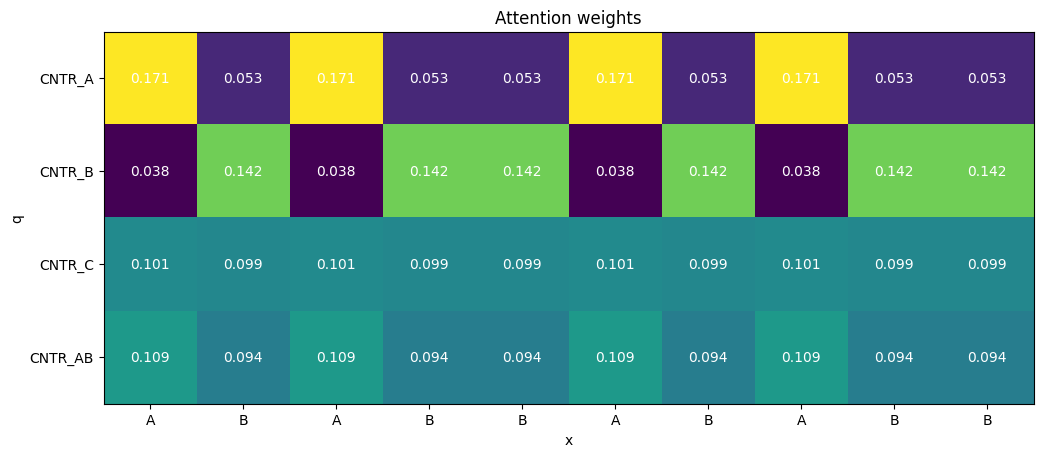

In [ ]:
import matplotlib.colors as colors

attention_weights_numpy = attention_weights.numpy().squeeze()
q_numpy = q.numpy().squeeze()

count_rows = attention_weights_numpy.shape[0]
count_columns = attention_weights_numpy.shape[1]

cell_size = 3
plt.figure(figsize = (cell_size * count_rows, count_columns * cell_size))
plt.imshow(attention_weights_numpy, extent=[0, count_columns, count_rows, 0])

for i in range(count_rows):
  for j in range(count_columns):
    e = attention_weights_numpy[i][j]
    e = np.round(e, 3)
    plt.annotate(str(e), xy=(j+0.5, i+0.5), ha='center', va='center', color='white')

plt.title("Attention weights")
plt.xlabel("x")
plt.ylabel("q")
plt.xticks(
    ticks=np.arange(0, count_columns) + 0.5,
    labels=str_seq(seq)
)
plt.yticks(
    ticks=np.arange(0, count_rows) + 0.5,
    labels=[id_to_query[id] for id in q_numpy]
)

plt.show()